<a href="https://colab.research.google.com/github/Atomix77/IMLO-IP/blob/main/IMLO_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data



In [46]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

trainingTransform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),])

validationTransform = transforms.Compose([ 
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

testTransform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),])

# def targetTransform(y):
#     return nn.functional.one_hot(torch.tensor(y), 102)

trainingData = datasets.Flowers102(
    root = "./datasets",
    split = "train",
    transform = trainingTransform,
    # target_transform = targetTransform,
    download = True)

validationData = datasets.Flowers102(
    root = "./datasets",
    split = "val",
    transform = validationTransform,
    # target_transform = targetTransform,
    download = True)

testData = datasets.Flowers102(
    root = "./datasets",
    split = "test",
    transform = testTransform,
    # target_transform = targetTransform,
    download = True)

# Dataloaders

In [47]:
batchSize = 64

trainingDataloader = DataLoader(trainingData, batchSize, shuffle = True, num_workers = 6)
validationDataloader = DataLoader(validationData, batchSize, shuffle = False, num_workers = 6)
testDataloader = DataLoader(testData, batchSize, shuffle = False, num_workers = 6)

# Get device

In [48]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Create Aritecture

In [49]:
class NeuralNetwork(nn.Module):
    def __init__(self, classAmount):
        super(NeuralNetwork, self).__init__()
        self.convStack =  nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Dropout(0.5)
        )
        self.classifier = nn.Sequential(
        nn.Linear(25088, 2048),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(2048, 1024),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, classAmount)
        )
    

    def forward(self, x):
        x = self.convStack(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = NeuralNetwork(102).to(device)

# Train Model

In [50]:
losses = []
def trainModel(dataloader, model, lossFunction, optimizer):
  model.train()
  currentLoss = 0.0
  correct = 0
  total = 0
  testLoss = 0
  
  for X, y in dataloader:
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    
    pred = model(X)
    loss = lossFunction(pred, y)

    loss.backward()
    optimizer.step()

    currentLoss += loss.item()

    total += y.size(0)
    testLoss += lossFunction(pred, y).item()
    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  
  testLoss = testLoss/total
  correct = correct/total

  losses.append(testLoss)
  
  print(f'Training: Accuracy {(100*correct):>0.1f}%, Loss: {currentLoss / len(dataloader):.5f}, Test Losss: {testLoss:.5f}')

# Validate Model

In [51]:
def validateModel(dataloader, model, lossFunction):
    model.eval()
    total = 0
    correct = 0
    testLoss = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            total += y.size(0)
            testLoss += lossFunction(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    testLoss = testLoss/total
    correct = (correct/total) * 100
    print(f"Validation: Accuracy: {(correct):>0.1f}%, Avg loss: {testLoss:>8f} \n")
    return testLoss, correct

# Test Model

In [52]:
def testModel(dataloader, model, lossFunction):
    model.eval()
    total = 0
    correct = 0
    testLoss = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            total += y.size(0)
            testLoss += lossFunction(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    testLoss = testLoss/total
    correct = (correct/total) * 100
    print(f"Testing: Accuracy: {(correct):>0.1f}%, Avg loss: {testLoss:>8f} \n")
    return testLoss, correct

# Model Evaluation

In [53]:
learningRate = 0.001
batchSize = 64
epochs = 150
bestValLoss = float('inf')
bestValAccuracy = 0.0
bestEpoch = 0
prevLearningRate = learningRate

lossFunction = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
adjustibleLearningRate = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

for epoch in range(epochs):
    print(f'Epoch {epoch+1}:')
    trainModel(trainingDataloader, model, lossFunction, optimizer)
    valLoss, valAccuracy = validateModel(validationDataloader, model, lossFunction)
    adjustibleLearningRate.step(valLoss)
    currentLearningRate = optimizer.param_groups[0]["lr"]
    
    if currentLearningRate != prevLearningRate:
        print(f'Learning rate changed from {prevLearningRate} to {currentLearningRate}')
        prevLearningRate = currentLearningRate

    if (valLoss < bestValLoss):
        bestValLoss = valLoss
        bestValAccuracy = valAccuracy
        bestEpoch = epoch+1

testModel(testDataloader, model, lossFunction)
print(f'Best Accuracy: {bestValAccuracy}. Best Loss: {bestValLoss}. Best Epoch: {bestEpoch}')
print("Finished")

Epoch 1:
Training: Accuracy 1.3%, Loss: 6.85236, Test Losss: 0.10749
Validation: Accuracy: 2.2%, Avg loss: 0.071629 

Epoch 2:
Training: Accuracy 1.0%, Loss: 4.64782, Test Losss: 0.07291
Validation: Accuracy: 3.2%, Avg loss: 0.068714 

Epoch 3:
Training: Accuracy 2.7%, Loss: 4.44872, Test Losss: 0.06978
Validation: Accuracy: 2.7%, Avg loss: 0.066075 

Epoch 4:


1st: Accuracy: 47.2%, Avg Loss: 0.038937
#
2nd: Accuracy: 46.8%, Avg Loss: 0.040024
#
3rd:  Accuracy: 46.4%, Avg Loss: 0.040268 

# Graph

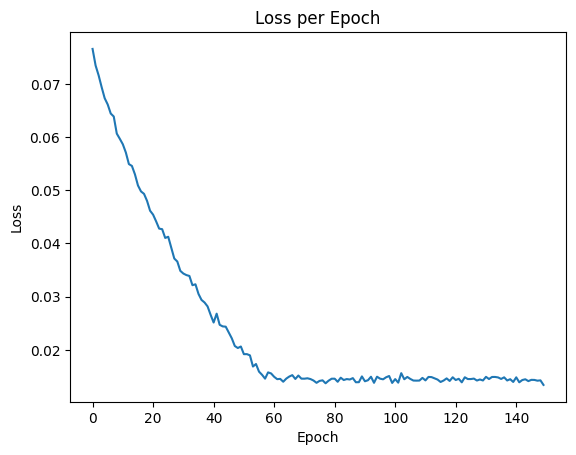

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss values
plt.plot(range(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.show()


# Saving the model

In [ ]:
# model = models.vgg16(weights='IMAGENET1K_V1')
# torch.save(model, 'model.pth')

# Loading the model

In [ ]:
# model = models.vgg16()
# model.load_state_dict(torch.load('model.pth'))
# model.eval()